In [99]:
import json
# from collections import defaultdict
from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
import numpy
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

In [100]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))
f.close()

In [101]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## How does the age of users influence their ratings of clothing items rented from Rent the Runway?

In [102]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'rating' in d and str(d['age']).isdigit() and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [103]:
ages = [int(d['age']) for d in clean_dataset]
ratings = [int(d['rating']) for d in clean_dataset]

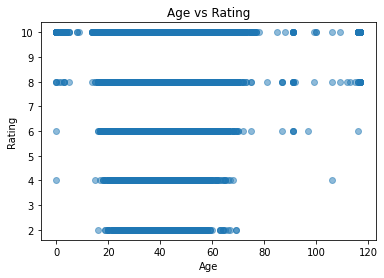

In [104]:
plt.scatter(ages, ratings, alpha=0.5)
plt.title('Age vs Rating')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.show()

In [105]:
# Prepare the data for linear regression
X = numpy.array([[1, age] for age in ages])  # Including the constant term
y = numpy.array(ratings).reshape(-1, 1)

In [106]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [107]:
theta = model.coef_
theta

array([[ 9.30426074e+00, -6.26219615e-03]])

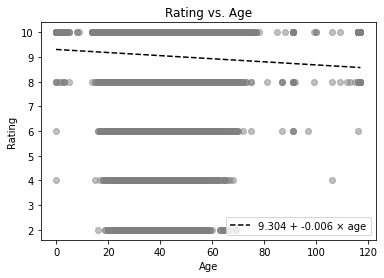

In [108]:
xplot = numpy.arange(min(ages), max(ages)+1)
yplot = [theta[0,0] + theta[0,1]*x for x in xplot]
plt.scatter(ages, ratings, color='grey', alpha=0.5)
plt.plot(xplot, yplot, color='k', linestyle='--', label=f"{theta[0,0]:.3f} + {theta[0,1]:.3f} × age")
plt.xlabel("Age")
plt.ylabel("Rating")
plt.title("Rating vs. Age")
plt.legend(loc='lower right')
plt.show()

In [109]:
df = pd.DataFrame(dataset)

## How do customer preferences and satisfaction, as indicated by the fit of rented items for different purposes, correlate with the overall trend in service usage over time?

In [110]:
# Convert 'review_date' to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

In [111]:
# Set the review_date as the index
df.set_index('review_date', inplace=True)

In [112]:
# Sort the data by date to prepare for the time series analysis
df.sort_index(inplace=True)

In [113]:
# Aggregating data by month to see the trend more clearly
monthly_data = df.resample('M').size()

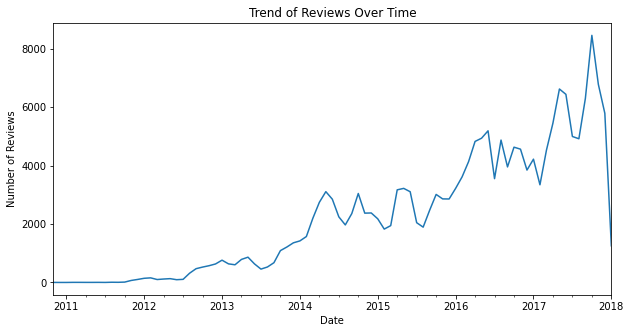

In [114]:
# Plotting the trend of reviews over time
plt.figure(figsize=(10, 5))
monthly_data.plot(title='Trend of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

In [115]:
# Replace 'nan' string with actual NaN and drop those rows
df['rented for'] = df['rented for'].replace('NaN', pd.NA)
df.dropna(subset=['rented for'], inplace=True)

In [116]:
# We will create a cross-tabulation of the 'fit' variable with the 'rented for' category
fit_rented_for_crosstab = pd.crosstab(df['fit'], df['rented for'])
fit_rented_for_crosstab

rented for,date,everyday,formal affair,other,party,party: cocktail,vacation,wedding,work
fit,,,,,,,,,
fit,5261,11608,31089,11334,25874,1,2914,43111,10857
large,935,3563,4451,2038,4546,0,669,6200,2304
small,1192,1651,4868,2016,5206,0,492,8473,1881


/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_29012/907045477.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


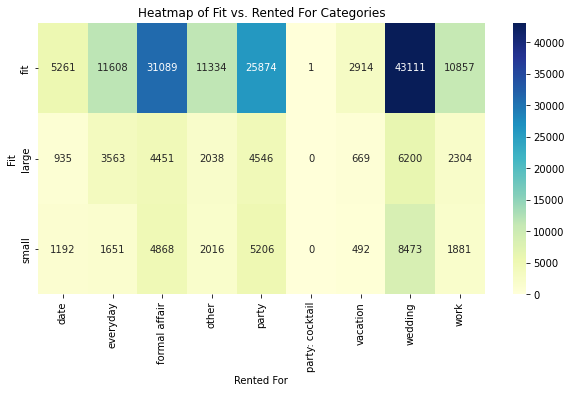

In [117]:
# Visualizing the cross-tabulation with a heatmap
plt.figure(figsize=(10, 5))

ax = sns.heatmap(fit_rented_for_crosstab, annot=True, fmt="d", cmap="YlGnBu")

# Set title and labels
ax.set_title('Heatmap of Fit vs. Rented For Categories')
ax.set_xlabel('Rented For')
ax.set_ylabel('Fit')

# Display the plot
ax.figure.show()

## How does age and review length correlate and how does it affect the overall rating of rented items?

In [118]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'review_text' in d and str(d['age']).isdigit():
        clean_dataset.append(d)

In [119]:
ages = [int(d['age']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

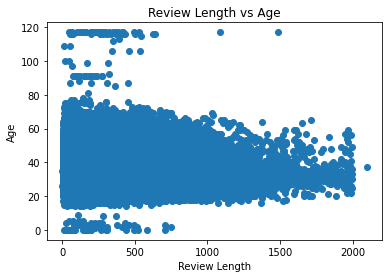

In [120]:
plt.scatter(reviewLen, ages)
plt.xlabel('Review Length')
plt.ylabel('Age')
plt.title('Review Length vs Age')

plt.show()

In [121]:
clean_dataset = []
for d in dataset:
    if 'rating' in d and 'review_text' in d and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [122]:
ratings = [int(d['rating']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

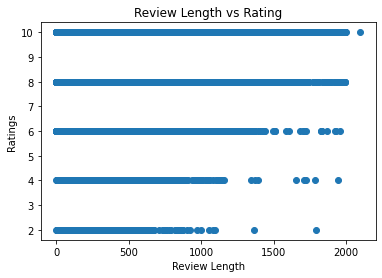

In [123]:
plt.scatter(reviewLen, ratings)
plt.xlabel('Review Length')
plt.ylabel('Ratings')
plt.title('Review Length vs Rating')

plt.show()

## What are the distribution of rating scores?

In [124]:
score_freq = df.groupby('rating').count().reset_index()
score_freq['rating'] = score_freq['rating'].astype(int)

score_freq = score_freq.sort_values(by='rating')

score_freq

,rating,fit,user_id,bust size,item_id,weight,rented for,review_text,body type,review_summary,category,height,size,age
1,2,1045,1045,945,1045,856,1045,1045,988,1045,1045,1037,1045,1041
2,4,2791,2791,2546,2791,2401,2791,2791,2622,2791,2791,2777,2791,2777
3,6,10697,10697,9773,10697,9111,10697,10697,10059,10697,10697,10657,10697,10650
4,8,53388,53388,48383,53388,45042,53388,53388,49663,53388,53388,53203,53388,53125
0,10,124531,124531,112411,124531,105085,124531,124531,114483,124531,124531,124101,124531,123900


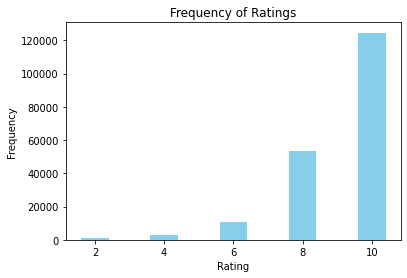

In [125]:
plt.bar(score_freq['rating'], score_freq['user_id'], color='skyblue')

# Add labels and title
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## What are the review averages based on age group?

In [126]:
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age
review_date,,,,,,,,,,,,,,
2010-11-03,fit,119679,36d,125564,NaN,10,wedding,This dress is amazing! I received so many comp...,hourglass,excellent customer servuce,gown,"5' 8""",25,38
2011-02-14,fit,635759,36c,126335,NaN,8,formal affair,This dress was beautiful! It's a little more p...,pear,"Stop, drop and stare. I got looks all night in...",dress,"5' 5""",16,38
2011-02-23,fit,201407,34b,126335,125lbs,10,formal affair,Amazing dress!! True to size and fit like a dr...,hourglass,The dress was super comfortable and super gorg...,dress,"5' 8""",8,32
2011-02-24,fit,566811,36c,125564,155lbs,10,wedding,Fabulous dress. First time on Runway and this...,hourglass,So flattering!!,gown,"5' 6""",21,37
2011-03-06,fit,252516,NaN,190529,NaN,10,formal affair,I LOVED wearing this dress!!! Since I'm just 5...,hourglass,The perfect LBD.,dress,"5' 0""",14,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-06,fit,900541,36dd,2559060,130lbs,10,vacation,So cute! Recommend.,hourglass,Felt great in this top. So cute! Recommend.,top,"5' 3""",8,50
2018-01-07,large,578131,36c,2526611,129lbs,10,party,"Unlike some other reviewers, I wore a size sma...",hourglass,"Such a nice skirt, easy & comfy to wear.",skirt,"5' 6""",8,60
2018-01-07,fit,273288,NaN,2499759,192lbs,10,party,"NYE 2018! My bff wore this she loved the fit, ...",NaN,BFF loves RTR!,jumpsuit,"5' 6""",20,52


In [129]:
age_mean = df
age_mean['rating'] = age_mean['rating'].fillna(0).astype(int)
age_mean['rating'] = age_mean['rating'].astype(int)
age_mean = df.groupby('age').mean().reset_index()
age_mean['age'] = age_mean['age'].astype(int)

age_mean = age_mean.sort_values(by='age')

age_mean

,age,rating,size
0,0,9.333333,11.708333
1,1,9.000000,10.000000
16,2,9.800000,23.400000
27,3,9.500000,16.833333
38,4,10.000000,4.555556
...,...,...,...
5,112,8.000000,12.000000
6,113,8.000000,20.000000
7,115,8.000000,17.000000
8,116,9.444444,7.444444


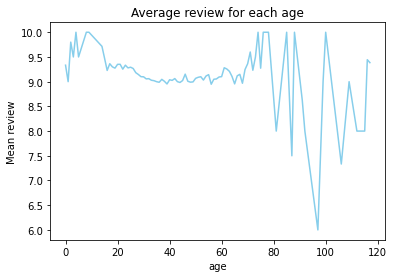

In [131]:
plt.plot(age_mean['age'], age_mean['rating'], color='skyblue')

# Add labels and title
plt.title('Average review for each age')
plt.xlabel('age')
plt.ylabel('Mean review')

# Show the plot
plt.show()

## Predictive task for Fit of Clothing
#### Given the body type, height, weight, and size of the user, can we predict if an item will fit well?

In [28]:
df = df.dropna(subset=['height'])

In [29]:
df['height_inches'] = df['height'].str.extract(r'(\d+)\' (\d+)\"').apply(
    lambda x: int(x[0]) * 12 + int(x[1]), axis=1
)

In [30]:
df['weight_lbs'] = df['weight'].str.extract(r'(\d+)lbs').astype(float)

In [31]:
df = df.dropna(subset=['height_inches', 'weight_lbs', 'body type', 'size', 'fit'])

In [32]:
label_encoders = {}
for column in ['body type', 'fit']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [33]:
fit_labels = {0: 'small', 1: 'fit', 2: 'large'}
df['fit_label'] = df['fit'].replace(fit_labels)

In [34]:
X = df[['height_inches', 'weight_lbs', 'body type', 'size']]
y = df['fit']

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [37]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [38]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
y_pred = model.predict(X_test)

In [40]:
y_pred_labels = label_encoders['fit'].inverse_transform(y_pred)

In [41]:
accuracy = accuracy_score(y_test, y_pred)

In [42]:
y_test_labels = label_encoders['fit'].inverse_transform(y_test)

In [43]:
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_labels, y_pred_labels, target_names=['small', 'fit', 'large']))

Accuracy: 0.7132386474688904
              precision    recall  f1-score   support

       small       0.74      0.95      0.83     22601
         fit       0.27      0.05      0.09      4068
       large       0.24      0.06      0.09      4029

    accuracy                           0.71     30698
   macro avg       0.42      0.35      0.34     30698
weighted avg       0.61      0.71      0.64     30698


#### How do customer preferences and satisfaction, as indicated by the fit of rented items for different purposes, correlate with the overall trend in service usage over time?

In [44]:
one_hot_encoder = OneHotEncoder()
rented_for_encoded = one_hot_encoder.fit_transform(df[['rented for']]).toarray()

In [45]:
feature_names = one_hot_encoder.get_feature_names_out(['rented for'])

In [46]:
rented_for_df = pd.DataFrame(rented_for_encoded, columns=feature_names, index=df.index)

In [47]:
df = df.join(rented_for_df)

In [48]:
features = df[feature_names]
labels = df['fit']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [50]:
model = linear_model.LogisticRegression(fit_intercept=False)
model.fit(X_train, y_train)

LogisticRegression(fit_intercept=False)

In [51]:
# Predict on the test set
y_pred = model.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred)

In [53]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.7333790587792857
